In [3]:
!pip install seaborn pandas matplotlib skunk svglib

In [1]:
import symd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pickle
import pandas as pd
import skunk
import svglib
import seaborn as sns

In [2]:
base_colors = ["f94144","f3722c","f8961e","f9844a","f9c74f","90be6d","43aa8b","4d908e","577590","277da1"]    
colors = ['#' + c for c in base_colors]
sns.set_style("white")
sns.set_style("ticks")
sns.set(rc={'axes.facecolor':'#f5f4e9', 
            'grid.color' : '#AAAAAA', 
            'axes.edgecolor':'#333333', 
            'figure.facecolor':'#FFFFFF', 
            'axes.grid': False,
            'axes.prop_cycle':   plt.cycler('color', plt.cm.Dark2.colors),
            'font.family': 'monospace'
           })
print(symd.__version__)

0.2.1


In [3]:
print("0\u2264x\u22641/2;0\u2264y\u22641")

0≤x≤1/2;0≤y≤1


In [4]:
rot = 5
genpos = []
for ri in range(rot):
    c = np.round(np.cos(ri * np.pi * 2 / rot), 4)
    s = np.round(np.sin(ri * np.pi * 2 / rot), 4)
    if ri == 1:
        #asymm = f'0≤x≤{c};0≤y≤{s}'
        asymm = f'1/2≤x≤1.0;1/2≤y≤1.0'
    genpos.append(f'{c}x {-s:+}y {-0.5 * c + 0.5 * s + 0.5:+},{s}x {c:+}y {-0.5 * s - 0.5 * c + 0.5:+}')
specpos = [{
            'name': 'a',
            'size': 1,
            'sites': ['1/2, 1/2']
            }]
    
my_group = {
    'lattice': 'Oblique',
    'genpos': genpos,
    'asymm_unit': asymm,
    'specpos': specpos
}
print(my_group)

{'lattice': 'Oblique', 'genpos': ['1.0x -0.0y +0.0,0.0x +1.0y +0.0', '0.309x -0.9511y +0.82105,0.9511x +0.309y -0.13005', '-0.809x -0.5878y +1.1984,0.5878x -0.809y +0.6106', '-0.809x +0.5878y +0.6106,-0.5878x -0.809y +1.1984', '0.309x +0.9511y -0.13005,-0.9511x +0.309y +0.82105'], 'asymm_unit': '1/2≤x≤1.0;1/2≤y≤1.0', 'specpos': [{'name': 'a', 'size': 1, 'sites': ['1/2, 1/2']}]}


In [25]:
def run_sim(n, number_density, group, images, w=None, retries=5, pos_frames=0, steps=10**6):
    for _ in range(retries):
        try:
            cell = symd.groups.get_cell(number_density, group, 2, n, w)
            md = symd.Symd(nparticles=n, cell=cell, ndims=2, images=images, force='lj', wyckoffs=w,
              group=group, steps=steps, exeDir='quasi', start_temperature=0.5, temperature=0.1, pressure=0.25)
            md.remove_overlap()            
            md.log_positions()
            try:
                md.run()
            except RuntimeError as e:
                d = md.number_density()
                if d < 0.6:
                    print('Not dense enough, retrying', d)
                    continue
            # NVT
            md.runParams['start_temperature'] = 0.0
            md.runParams['temperature'] = 1e-3
            md.runParams['Pressure'] = None
            md.runParams['box_update_period'] = 0
            md.runParams['steps'] = steps // 4
            if pos_frames > 0:
                md.log_positions(filename='equil.xyz', frames=pos_frames)
            try:
                md.run()
            except RuntimeError as e:
                continue
            config = md.positions[-1]
            break
        except RuntimeError as e:
            print(e)
            md = None
    return md


In [26]:
md = run_sim(100, 0.1, my_group, [0, 0], pos_frames=2000, w=[1])

{"steps": 1000000, "n_particles": 100, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.1, "pressure": 0.25, "box_update_period": 5, "start_temperature": 0.1, "thermostat": "baoab", "force_type": "lj", "final_positions": "quasi/final_positions.dat", "cell_log_file": "quasi/cell_log_file.dat", "print_period": 10000.0, "cell": [33.6014, 0.0, 0.0, 31.9831], "lj_epsilon": 1, "lj_sigma": 1, "images": [0, 0], "start_positions": "quasi/final_positions.dat", "group": "quasi/group-custom.json", "wyckoffs": [{"group": "quasi/group-custom-00.json", "n_particles": 1}], "position_log_period": 10000, "positions_log_file": "quasi/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-custom with 99 particles and 5 members
Info: Loaded group group-custom-0 with 1 particles and 1 membe

{"steps": 1000000, "n_particles": 100, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.1, "pressure": 0.25, "box_update_period": 5, "start_temperature": 0.1, "thermostat": "baoab", "force_type": "lj", "final_positions": "quasi/final_positions.dat", "cell_log_file": "quasi/cell_log_file.dat", "print_period": 10000.0, "cell": [33.2528, 0.0, 0.0, 32.8815], "lj_epsilon": 1, "lj_sigma": 1, "images": [0, 0], "start_positions": "quasi/final_positions.dat", "group": "quasi/group-custom.json", "wyckoffs": [{"group": "quasi/group-custom-00.json", "n_particles": 1}], "position_log_period": 10000, "positions_log_file": "quasi/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-custom with 99 particles and 5 members
Info: Loaded group group-custom-0 with 1 particles and 1 membe

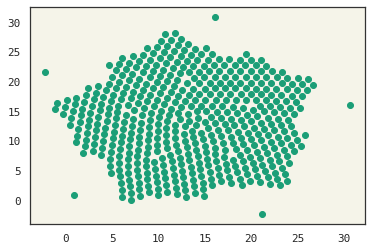

In [27]:
plt.plot(md.positions[-1,:,0], md.positions[-1,:, 1], 'o')

In [32]:
# make a movie
import moviepy.editor as editor
from moviepy.video.io.bindings import mplfig_to_npimage


def plot_traj(traj, title='@_172135352171_', color='#333333', fps=60):
    T, N, D = traj.shape    
    fps = fps
    duration = T / fps
    dpi = 90
    fig, ax = plt.subplots(figsize=(1200 / dpi, 800 / dpi), dpi=dpi)    
    points = ax.plot(traj[0,:,0], traj[0,:,1], color=color, marker='o', markersize=15, markeredgewidth=1.0, linestyle='None', alpha=1.0)[0]
    ax.set_facecolor('#f5f4e9')
    fig.patch.set_facecolor('#f5f4e9')
    title = ax.set_title(title, fontsize=32, color='#333333',fontname='monospace')
    ax.axis('off')
    #xlim = np.quantile(traj[-1,:,0], [0.3, 0.8])
    #ylim = np.quantile(traj[-1,:,1], [0.3, 0.8])
    xlim = (0,30)
    ylim = (0,30)
    ax.set_aspect('equal')    
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    #plt.tight_layout()
    def make_frame(t):
        i = int(t  * fps)
        i = min(i, T-1)
        points.set_data(traj[i,:,0], traj[i,:,1])    
        return mplfig_to_npimage(fig)

    return editor.VideoClip(make_frame, duration=duration)
def write_video(clips, output, fps=60, transition=0.25):
    composite = editor.concatenate(clips[:1] + [c.crossfadein(transition) for c in clips[1:]], 
                                   padding=-transition, method='compose')   
    composite.write_videofile(output, fps=fps, preset='slower', ffmpeg_params=['-tune', 'animation'])

In [ ]:
c = plot_traj(md.positions)
write_video([c], 'reflect.mp4')

t:  34%|█████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                     | 684/1997 [03:05<00:35, 36.57it/s, now=None]

Moviepy - Building video reflect.mp4.
Moviepy - Writing video reflect.mp4




t:   5%|████████████▎                                                                                                                                                                                                                      | 108/1997 [00:03<01:01, 30.81it/s, now=None]


t:  11%|████████████████████████▉                                                                                                                                                                                                          | 219/1997 [00:07<00:56, 31.50it/s, now=None]


t:  17%|█████████████████████████████████████▌                                                                                                                                                                                             | 331/1997 [00:10<00:49, 33.34it/s, now=None]


t:  22%|██████████████████████████████████████████████████▎                                                                                                                                                                                | 443/1997 [00:13<00:48, 32.24it/s, now=None]


t:  28%|███████████████████████████████████████████████████████████████                                                                                                                                                                    | 555/1997 [00:17<00:45, 31.65it/s, now=None]


t:  33%|███████████████████████████████████████████████████████████████████████████▊                                                                                                                                                       | 667/1997 [00:20<00:40, 32.56it/s, now=None]


t:  39%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                           | 775/1997 [00:24<00:40, 30.24it/s, now=None]


t:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                              | 884/1997 [00:27<00:34, 32.38it/s, now=None]


t:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                 | 996/1997 [00:31<00:30, 33.01it/s, now=None]


t:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                    | 1108/1997 [00:34<00:27, 31.94it/s, now=None]


t:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 1207/1997 [00:38<00:30, 26.13it/s, now=None]


t:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 1295/1997 [00:41<00:25, 27.56it/s, now=None]


t:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 1381/1997 [00:44<00:22, 27.43it/s, now=None]


t:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 1466/1997 [00:47<00:19, 27.14it/s, now=None]


t:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 1552/1997 [00:51<00:16, 27.07it/s, now=None]


t:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 1636/1997 [00:54<00:13, 27.38it/s, now=None]


t:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 1730/1997 [00:57<00:09, 29.63it/s, now=None]


t:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 1816/1997 [01:00<00:07, 25.07it/s, now=None]


t:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 1894/1997 [01:03<00:03, 28.46it/s, now=None]